In [1]:
!pip3 install tensorflow.python.tools

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow.python.tools (from versions: none)
ERROR: No matching distribution found for tensorflow.python.tools


In [2]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import geopandas as gpd

In [3]:
import tensorflow as tf
import keras

2022-12-06 04:58:07.182774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 04:58:07.351710: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 04:58:07.355778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-06 04:58:07.355795: I tensorf

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.wrappers.scikit_learn import KerasClassifier


In [93]:
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm

In [5]:
df = pd.read_csv('clean25kDataset.csv')

In [6]:
timestamp_list = []
for d, t in zip(df['Date'], df['Time']):
    timestamp = datetime.datetime.strptime(d+' '+t, '%Y-%m-%d %H:%M:%S')
    timestamp_list.append(time.mktime(timestamp.timetuple()))
    
timeStamp = pd.Series(timestamp_list)
df['Timestamp'] = timeStamp.values
clean_df = df.drop(['Date', 'Time'], axis=1)

clean_df = clean_df.rename(columns={'Lat': 'Latitude', 'Lon': 'Longitude', 'Mag': 'Magnitude'})
clean_df


,Latitude,Longitude,Depth,Magnitude,Region,Timestamp
0,60.5758,-147.5620,15.1,2.6,"57 km SW of Tatitlek, Alaska",1.670283e+09
1,37.3565,-121.7167,8.2,1.5,"10km E of Alum Rock, CA",1.670283e+09
2,60.1315,-153.1349,125.6,1.9,"66 km E of Port Alsworth, Alaska",1.670282e+09
3,37.3247,-121.6887,6.9,3.7,"13km ESE of Alum Rock, CA",1.670282e+09
4,39.4327,-92.2425,4.7,2.5,"5 km SSW of Madison, Missouri",1.670282e+09
...,...,...,...,...,...,...
24995,58.2855,-154.9823,3.8,0.5,"85 km NNW of Karluk, Alaska",1.664120e+09
24996,51.3816,142.7739,10.0,4.8,"51 km NE of Mgachi, Russia",1.664120e+09
24997,27.7017,56.4543,10.0,4.9,"59 km NNE of Bandar Abbas, Iran",1.664120e+09
24998,35.3747,-118.1223,4.5,1.1,"30km NNW of California City, CA",1.664119e+09


In [96]:
max(clean_df['Magnitude'])

7.3

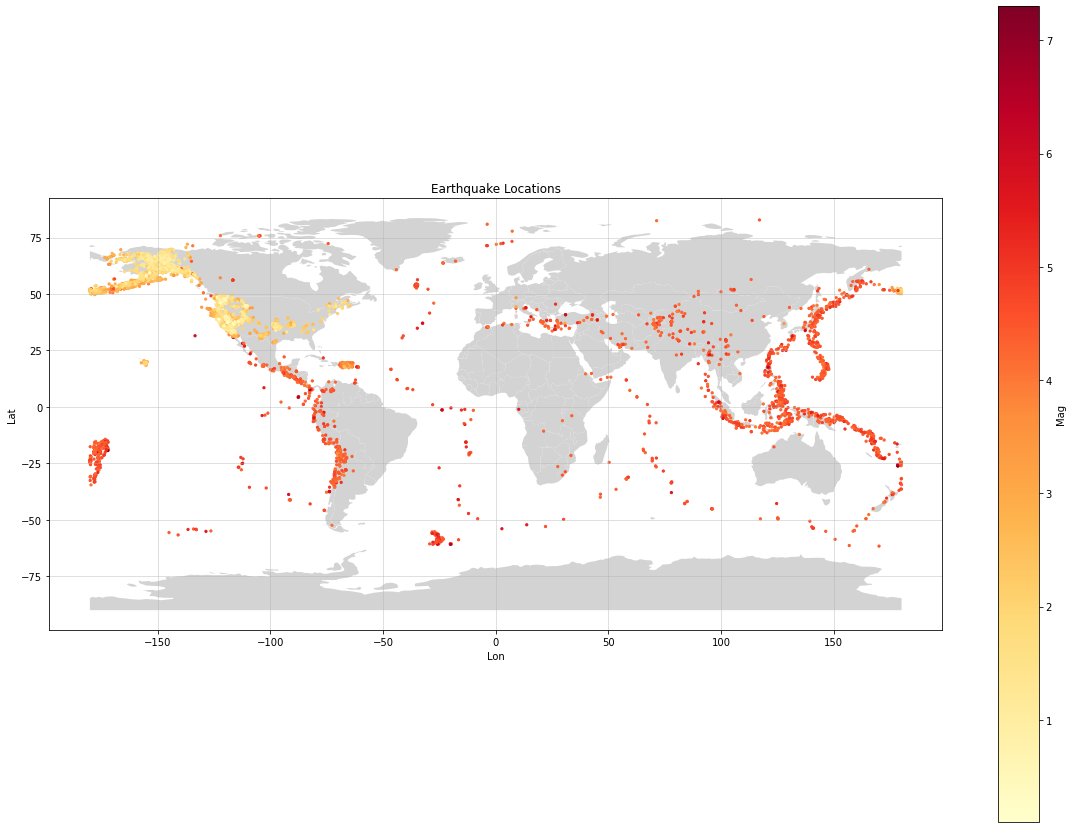

In [99]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(20,15))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
df.plot(x="Lon", y="Lat", marker ='.', kind="scatter", c="Mag", colormap="YlOrRd", 
        title="Earthquake Locations", ax=ax)

# add grid
ax.grid(visible=True, alpha=0.5)

plt.show()



In [85]:
X = clean_df[['Timestamp', 'Latitude', 'Longitude']]
y = clean_df[['Magnitude']]
X = X.to_numpy() 
y = y.to_numpy().reshape(-1, 1)

(20000, 3) (5000, 3) (20000, 1) (5000, 1)


(20000, 3, 1, 1) (5000, 3, 1, 1) (20000, 1) (5000, 1)


In [88]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [89]:
svr = SVR().fit(X, y.ravel())
yfit = svr.predict(X)

In [90]:
X = sc_X.inverse_transform(X)
y = sc_y.inverse_transform(y)
yfit = sc_y.inverse_transform(yfit)

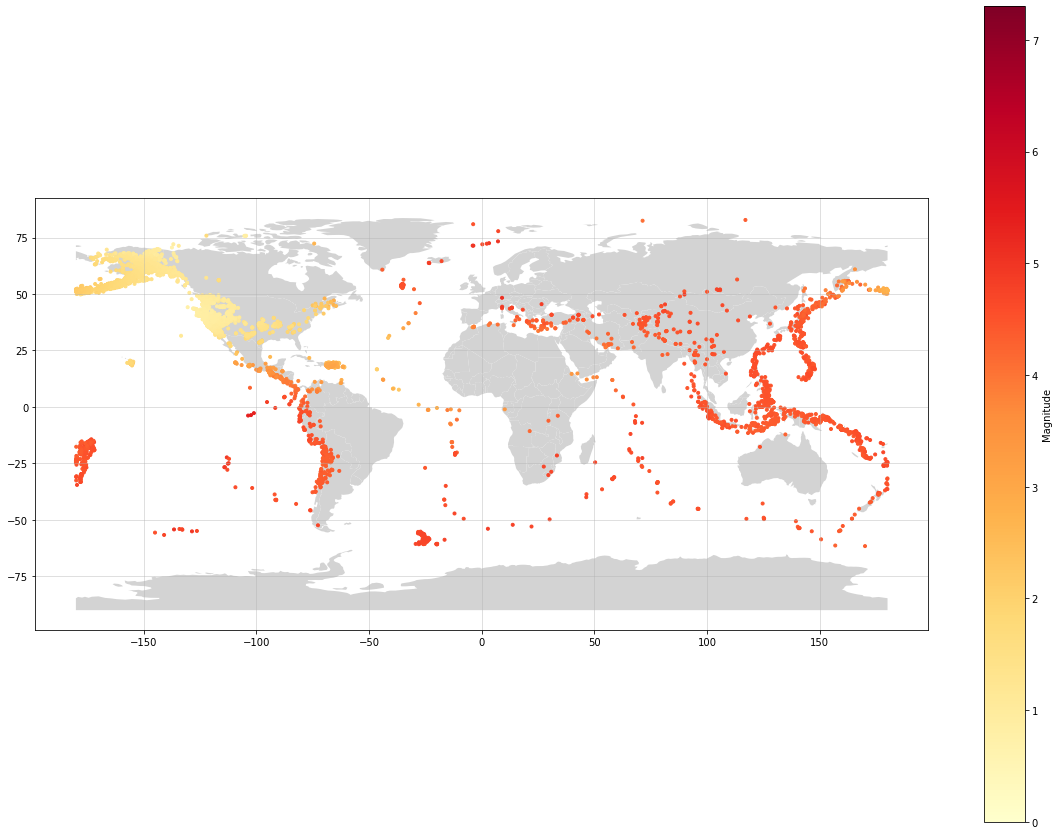

In [98]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(20,15))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
plt.scatter(X[:,2], X[:,1], marker ='.', c=yfit)
plt.set_cmap("YlOrRd")
plt.colorbar(label="Magnitude", orientation="vertical")
plt.clim(0,7.3)

# add grid
ax.grid(visible=True, alpha=0.5)

plt.show()

In [65]:
score = svr.score(X,y[:,0])
print("R-squared:", score)
print("MSE:", mean_squared_error(y[:,0], yfit))

R-squared: 0.7302950423745145
MSE: 0.2697049576254855


In [106]:
yfit = yfit.reshape(-1,1)
newy = y-yfit
newy = np.power(newy,2)
newy = newy.reshape(-1,1)

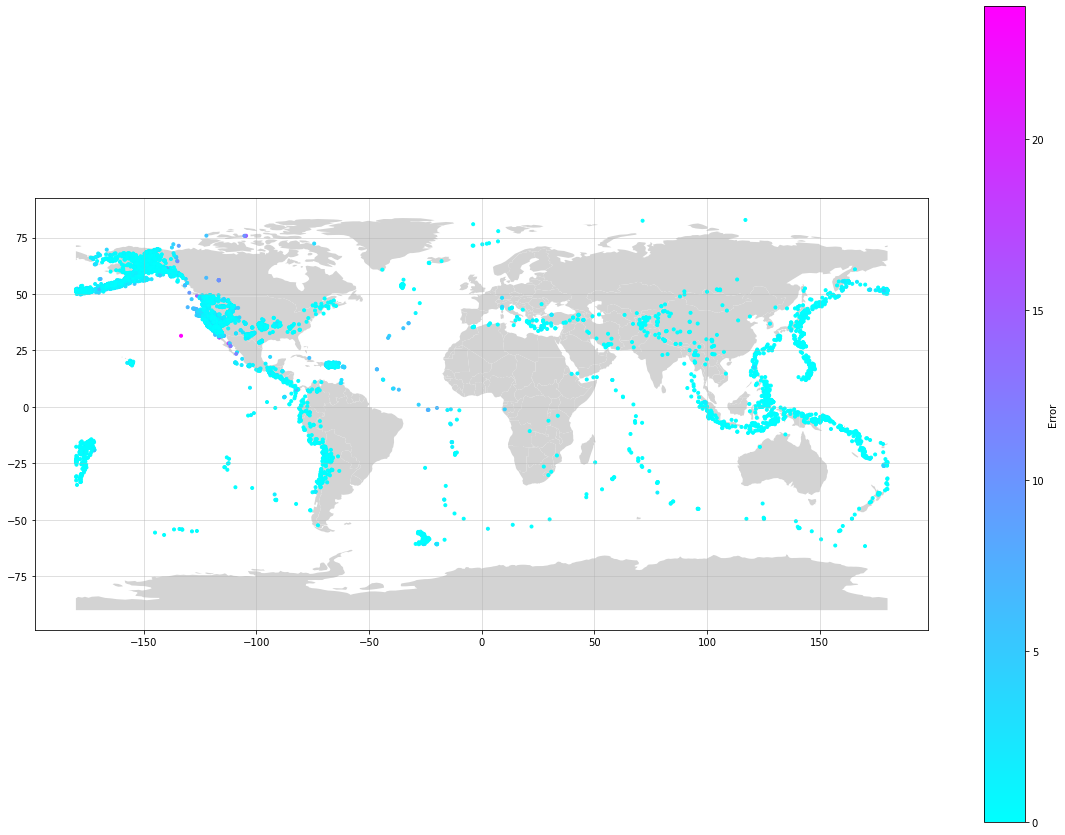

In [112]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(20,15))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
plt.scatter(X[:,2], X[:,1], marker ='.', c=newy)
plt.set_cmap("cool")
plt.colorbar(label="Error", orientation="vertical")

# add grid
ax.grid(visible=True, alpha=0.5)

plt.show()